In [1]:
#first import necessary packages
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
import nltk
from bs4 import BeautifulSoup

from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

stopwords= nltk.corpus.stopwords.words('english')
warnings.filterwarnings("ignore")

In [2]:
#read the dataset
data = pd.read_csv('imdbds.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [4]:
print(data.describe())
X=data['review']
y=data['sentiment']

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


In [5]:
def remove_special_characters(text):
    """Function to parse raw review data and extract
        text from it.
    """
    soup = BeautifulSoup(text, "html.parser")
    text = soup.get_text()
    text = re.sub('\[[^]]*\]', '', text)
    text = re.sub('[^a-zA-z0-9\s+\,]','',text)
    text = re.sub('\.{2,}','',text)
    return text

def remove_stopwords(text):
    """Function to remove stopwords"""
    text = text.lower()
    words = text.split(" ")
    filtered_words = [i for i in words if i not in stopwords]
    filtered_words = ' '.join(filtered_words)
    return filtered_words

class BuildVocab:
    """Class to build vocabulary for a given series of reviews and vocab size"""
    def __init__(self, sentences: pd.Series, vocab_size:int, unk_token=False):
        self.sentences = sentences
        self.vocab_size = vocab_size
        self.oov_token = unk_token
    
    def __process_sentences(self, sentence:str):
        sentence = re.sub(r'[^a-zA-Z\s+]', '', sentence).strip()
        return sentence
    
    def __sentence2words(self, sentence: str):
        word_list = list()
        for word in sentence.split(" "):
            if len(word) >= 1:
                word_list.append(word)
            else:
                pass
        return list(word_list)
    
    def __get_word_dictionary(self, sentences:list):
        words = list()
        for sentence in sentences:
            word_list = self.__sentence2words(sentence=sentence)
            words.extend(word_list)
        return list(words)
    
    def __get_topn_words(self, word_dictionary:dict):
        sorted_items = sorted(word_dictionary.items(), key=lambda item: item[1], reverse=True)
        top_n_words = [word for word, _ in sorted_items[:self.vocab_size]]
        return top_n_words


    def build(self):
        sentences = self.sentences.apply(self.__process_sentences)
        words = self.__get_word_dictionary(sentences=sentences.values)
        word_count_dict = Counter(words)
        vocab = self.__get_topn_words(word_dictionary=word_count_dict)
        
        if self.oov_token:
            vocab.append("UNK")
        else:
            pass

        index_dict = {x: index for x, index in zip(vocab, range(len(vocab)))}

        return vocab, index_dict

Number of reviews: 50000


<Axes: xlabel='sentiment', ylabel='count'>

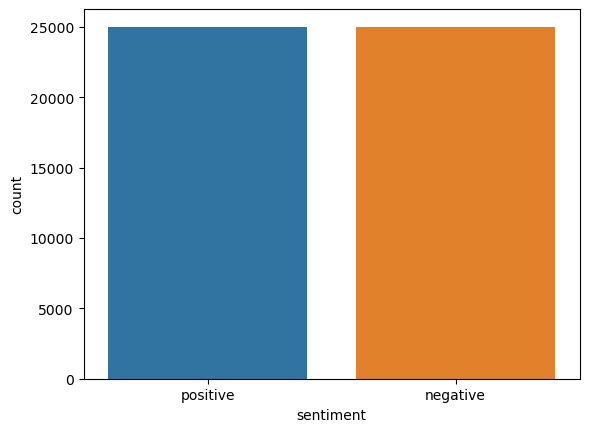

In [7]:
print(f"Number of reviews: {len(X.values)}")
sns.countplot(data=data, x="sentiment")

In [8]:
#cleaning and removing stopwords from reviews
X = X.apply(remove_special_characters)
X = X.apply(remove_stopwords)

In [9]:
## Building vocabulary with desired vocab size
vocab, vocab_dict = BuildVocab(sentences=X, vocab_size=1000, unk_token=True).build()

In [10]:
from sklearn.model_selection import train_test_split
#splitting dataset into 75% train and 25% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    random_state=0)

In [11]:
tfidf = TfidfVectorizer(max_features = 500)
tfidf = tfidf.fit(X_train)
X_train, X_test = tfidf.transform(X_train), tfidf.transform(X_test)

In [12]:
encoder = LabelBinarizer()
encoder = encoder.fit(y_train)
y_train,y_test = encoder.transform(y_train), encoder.transform(y_test)
print(y_train.shape, y_test.shape)

(37500, 1) (12500, 1)


In [13]:
lr = LogisticRegression(penalty="l2", max_iter=500, C=1, random_state=42)
lr = lr.fit(X_train, y_train)

In [14]:
#checking accuracy
train_pred = lr.predict(X_train)
test_pred = lr. predict(X_test)
train_acc = accuracy_score(y_train,train_pred)
print("Training accuracy: {}".format(train_acc))
test_acc = accuracy_score(y_test, test_pred)
print("Testing accuracy: {}".format(test_acc))
f1train = f1_score(y_train, train_pred)
print("F1 score(train): {}".format(f1train))
f1test = f1_score(y_test, test_pred)
print("F1 Score(test): {}".format(f1test))

Training accuracy: 0.8459466666666666
Testing accuracy: 0.83248
F1 score(train): 0.8477051643687555
F1 Score(test): 0.8331208160663054


In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test,test_pred))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      6291
           1       0.82      0.84      0.83      6209

    accuracy                           0.83     12500
   macro avg       0.83      0.83      0.83     12500
weighted avg       0.83      0.83      0.83     12500



<Axes: >

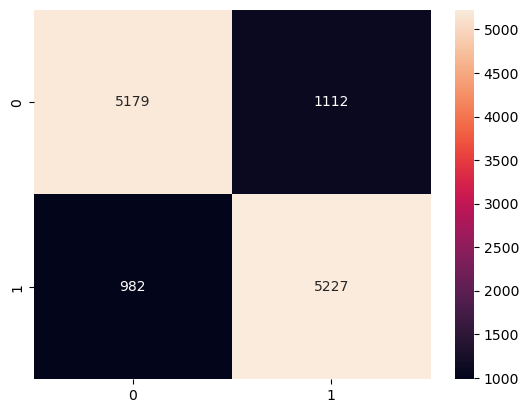

In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,test_pred)
sns.heatmap(cm, fmt='d', annot=True)